In [82]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [83]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()#형태소 토큰화 여기서는 형태소 분석기 중에서 mecab을 사용해보겠습니다
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 word for word 질문 ? 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()#같은 레벨에 있는 데이터끼리 묶어준다 
    counter = Counter(words)##[a,'b']
    counter = counter.most_common(10000-4)
    
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #사전 구성
        
    def wordlist_to_indexlist(wordlist): # 텍스트 스트링을 인덱스 스트링으로 변환 
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [84]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[3])



In [85]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<굳>"] = 1
word_to_index["<떽>"] = 2  # unknown
word_to_index["<라>"] = 3

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['오늘'])  # 4 이 출력됩니다. 
print(index_to_word[2])     # 'the' 가 출력됩니다.

<굳>
493
<떽>


In [86]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [87]:

import numpy as np
import tensorflow as tf
import os

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)



(146182, 41)


In [117]:
vocab_size = 30000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 40  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)
from tensorflow.keras import regularizers

tf.keras.regularizers.l2(l2=0.09)
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))

#word_vector_dim 이 값이 128이라면 단어를 128차원의 의미론적 기하공간에 나타낸다는 의미입니다.
# model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(3))
model.add(keras.layers.Bidirectional(GRU(16, return_sequences=True,dropout=0.8)))
model.add(keras.layers.Bidirectional(GRU(16, return_sequences=True,dropout=0.5)))
model.add(keras.layers.Bidirectional(GRU(16, return_sequences=True,dropout=0.5)))
model.add(keras.layers.Dense(8, activation='relu',kernel_regularizer='l2'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


model.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, None, 40)          1200000   
_________________________________________________________________
bidirectional_39 (Bidirectio (None, None, 32)          5568      
_________________________________________________________________
bidirectional_40 (Bidirectio (None, None, 32)          4800      
_________________________________________________________________
bidirectional_41 (Bidirectio (None, None, 32)          4800      
_________________________________________________________________
dense_42 (Dense)             (None, None, 8)           264       
_________________________________________________________________
dense_43 (Dense)             (None, None, 1)           9         
Total params: 1,215,441
Trainable params: 1,215,441
Non-trainable params: 0
___________________________________________

In [118]:
# validation set 10000건 분리
x_val = X_train[:100000]   
y_val = y_train[:100000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[100000:]  
partial_y_train = y_train[100000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(46182, 41)
(46182,)


# Y 의 형태는 x 의 쉐잎보다 차원이 낮다는 점을 명심한다 

In [119]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=12  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/12
1444/1444 [==============================] - 47s 28ms/step - loss: 0.5051 - accuracy: 0.7517 - val_loss: 0.4257 - val_accuracy: 0.8074
Epoch 2/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.3783 - accuracy: 0.8388 - val_loss: 0.3684 - val_accuracy: 0.8426
Epoch 3/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.3450 - accuracy: 0.8559 - val_loss: 0.3651 - val_accuracy: 0.8449
Epoch 4/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.3218 - accuracy: 0.8673 - val_loss: 0.3645 - val_accuracy: 0.8458
Epoch 5/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.3085 - accuracy: 0.8734 - val_loss: 0.3675 - val_accuracy: 0.8463
Epoch 6/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.2954 - accuracy: 0.8792 - val_loss: 0.3609 - val_accuracy: 0.8474
Epoch 7/12
1444/1444 [==============================] - 39s 27ms/step - loss: 0.2854 - accuracy: 0.8842 - val_loss: 0.3757 -

In [120]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 12s - loss: 0.3829 - accuracy: 0.8409
[0.3829200565814972, 0.8409061431884766]


In [121]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


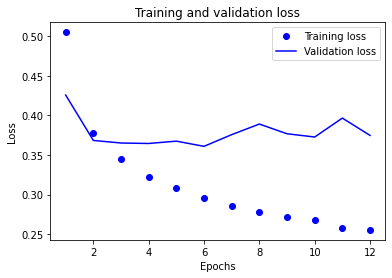

In [122]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss') #X 축 , y 축 으로 타이핑  
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

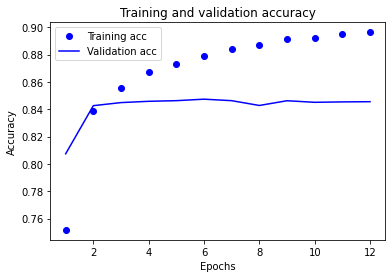

In [123]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [116]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 40)


In [60]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 



In [61]:
gensim.__version__
from gensim.models import KeyedVectors

In [62]:
from tensorflow.keras.initializers import Constant
# 임베딩 레이어 변경
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim
import numpy as np
import keras
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/ko.bin'

word2vec = gensim.models.Word2Vec.load(word2vec_path) 
#pretrained word embedding
#이미 주어진 모델로 워드 벡터로 활용 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
#이부분이 가장 어려운 부분이었다

#embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(9,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


p1 = word2vec.wv.most_similar("행복") 
print(p1)
print('-'*90)
p2 = word2vec.wv.most_similar("주식") 
print(p1)
print('-'*90)
p3 =  word2vec.wv.most_similar("하락")
print(p3)
print('-'*90)
# for i in range(4,vocab_size):
#     if index_to_word[i] in word2vec:
#         embedding_matrix[i] = word2vec[index_to_word[i]]

# word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_path, binary=False)
# vector = word_vectors['한']
# vector

[('사랑', 0.6759077310562134), ('기쁨', 0.6493781805038452), ('즐거움', 0.6396492719650269), ('삶', 0.6299898028373718), ('젊음', 0.6187379360198975), ('즐겁', 0.6027448177337646), ('인생', 0.6002243161201477), ('존엄', 0.5952589511871338), ('고독', 0.5938762426376343), ('불행', 0.5894461870193481)]
------------------------------------------------------------------------------------------
[('사랑', 0.6759077310562134), ('기쁨', 0.6493781805038452), ('즐거움', 0.6396492719650269), ('삶', 0.6299898028373718), ('젊음', 0.6187379360198975), ('즐겁', 0.6027448177337646), ('인생', 0.6002243161201477), ('존엄', 0.5952589511871338), ('고독', 0.5938762426376343), ('불행', 0.5894461870193481)]
------------------------------------------------------------------------------------------
[('상승', 0.8115789294242859), ('급락', 0.7797585725784302), ('급등', 0.7704669833183289), ('폭등', 0.756759524345398), ('폭락', 0.7319166660308838), ('감소', 0.7212550044059753), ('증가', 0.6945136785507202), ('저하', 0.6796392798423767), ('상승률', 0.6793742179870605), ('급

/tmp/ipykernel_287/632372507.py:24: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_287/632372507.py:25: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


# Bidirectional GRU, LSTM stack 을 이용해서 훈련
# GRU 보다 더 좋음이 확인되었다!
## dropout 을 통해 더 정규화하여서 loss, 정확도가 좋아졌다


(106182, 41)
(106182,)
(146182, 41)
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 41, 128)           135680    
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 41, 128)           98816     
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 41, 128)           98816     
_________________________________________________________________
dense_32 (Dense)             (None, 41, 8)             1032      
_________________________________________________________________
dense_33 (Dense)             (None, 41, 1)             9         
Total params: 2,334,353
Trainable params: 2,334,353
Non-trainable params: 0
_______

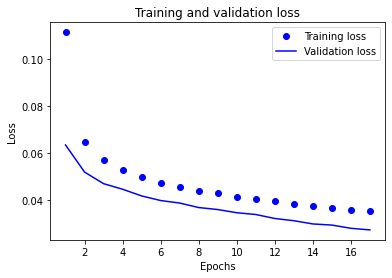

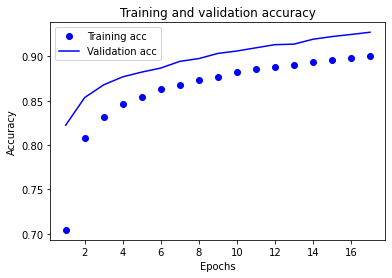

In [81]:
# 임베딩 레이어 변경
tf.keras.regularizers.l2(l2=0.06)
from keras.layers import Input, Dense, LSTM, GRU, Bidirectional
vocab_size = 50000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 500  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                       value=word_to_index["<PAD>"],
                                                     padding='post', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                       value=word_to_index["<PAD>"],
                                       padding='post',
                                       maxlen=maxlen)

x_val = X_train[:40000]
y_val = y_train[:40000]

#validation set을 제외한 나머지는 train set으로 사용
partial_x_train = X_train[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

print(X_train.shape)

# 모델 설계
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 # 카피한 임베딩을 여기서 활용!!!
                                 input_length=maxlen, 
                                 trainable=True))   
# trainable을 True로 주면 Fine-tuning
#임베딩 레이어 다음에 LSTM 레이어가 오는 경우에는 임베딩 레이어에 input_length 인자를 따로 설정할 필요는 없습니다. 
model.add(keras.layers.Bidirectional(LSTM(64, return_sequences=True,dropout=0.5)))
model.add(keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
model.add(keras.layers.Bidirectional(LSTM(64, return_sequences=True)))
model.add(keras.layers.Dense(8, activation='relu',kernel_regularizer='l2'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

# 모델 학습
model.compile(optimizer='adam',
              loss='MeanSquaredLogarithmicError',
              metrics=['accuracy'])

epochs=17

patial_x_train = np.asarray(partial_x_train)
patial_y_train = np.asarray(partial_y_train)



history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=350,
                    validation_data=(x_val, y_val),
                    verbose=1)

# 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

# 모델의 fitting 과정 중의 정보들이 history 변수에 저장
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

# 도식화 Training and Validation loss
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Training and Validation accuracy
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# epoch 14 부터 일치하게 된다. 
# LSTM 3층으로 stack 하였다
## L2 수치를 조정하며(0.06) 더욱 이격을 줄어들게 하였다 

# GRU, relu 스택 레이어 사용한 모델(아래)


In [ ]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 200

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 # 카피한 임베딩을 여기서 활용!!! 차원늘리는거인듯 
                                 input_length=maxlen, 
                                 trainable=True))

model.add(tf.keras.layers.GRU(128, return_sequences=True)) 
model.add(tf.keras.layers.GRU(64, return_sequences=True)) 

model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

In [ ]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

In [116]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.3430 - accuracy: 0.8551
[0.3429652452468872, 0.8551172614097595]


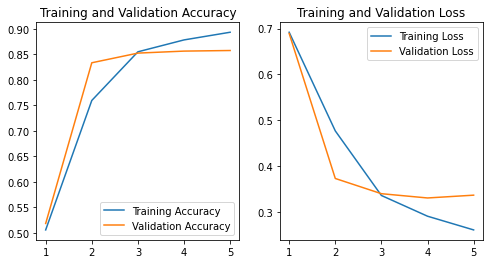

In [117]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### validation loss의 그래프가 train loss와의 이격이 발생하게 되면 더이상의 트레이닝은 무의미해진다

# 밑은 활성화함수 GELU 를 이용한 모델


In [75]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='ELU'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [76]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.5994 - accuracy: 0.7311 - val_loss: 0.4520 - val_accuracy: 0.8021
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3899 - accuracy: 0.8313 - val_loss: 0.3689 - val_accuracy: 0.8366
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3322 - accuracy: 0.8591 - val_loss: 0.3551 - val_accuracy: 0.8439
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3018 - accuracy: 0.8741 - val_loss: 0.3535 - val_accuracy: 0.8464
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2796 - accuracy: 0.8849 - val_loss: 0.3576 - val_accuracy: 0.8466


In [77]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3654 - accuracy: 0.8429
[0.3654142916202545, 0.842870831489563]


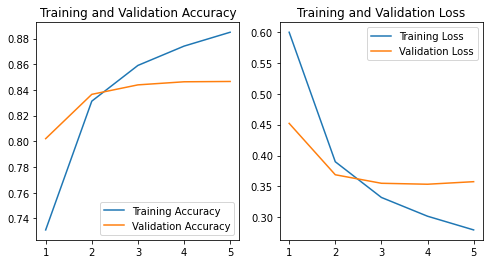

In [78]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [79]:
#어휘 사전의 크기(10,000개의 단어)
vocab_size = 10000    

#단어 하나를 표현하는 임베딩 벡터의 차원수(변경가능)
word_vector_dim = 16  

#GlobalMaxPooling1D레이어 하나만 사용한 모델
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='ELU',kernel_regularizer='l2'))

model.add(keras.layers.Dense(8, activation='ELU',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  #최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 9         
Total params: 160,217
Trainable params: 160,217
Non-trainable params: 0
_________________________________________________________________


In [80]:
#GlobalMaxPooling1D레이어 하나만 사용한 모델 학습
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=5

history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/5
208/208 [==============================] - 1s 4ms/step - loss: 0.5423 - accuracy: 0.7587 - val_loss: 0.3850 - val_accuracy: 0.8295
Epoch 2/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3496 - accuracy: 0.8491 - val_loss: 0.3547 - val_accuracy: 0.8441
Epoch 3/5
208/208 [==============================] - 1s 4ms/step - loss: 0.3044 - accuracy: 0.8732 - val_loss: 0.3531 - val_accuracy: 0.8471
Epoch 4/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2746 - accuracy: 0.8880 - val_loss: 0.3612 - val_accuracy: 0.8472
Epoch 5/5
208/208 [==============================] - 1s 4ms/step - loss: 0.2512 - accuracy: 0.9002 - val_loss: 0.3756 - val_accuracy: 0.8439


In [81]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 2s - loss: 0.3839 - accuracy: 0.8409
[0.38390836119651794, 0.8409178853034973]


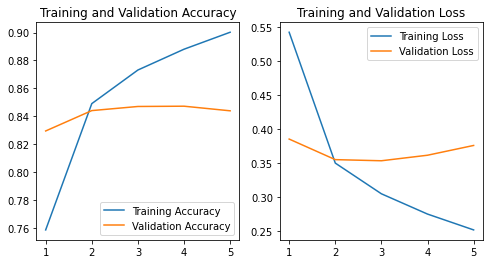

In [82]:
#Loss, Accuracy 그래프 시각화

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# Accuracy 그래프
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()